In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surjodey","key":"ba440bbd514303c777b3d0fa0c9420f4"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)  # Create the directory if it doesn't exist
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')  # Move the kaggle.json file to the correct location


In [4]:
!kaggle datasets download -d slothkong/10-monkey-species -p /content/


Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
100% 545M/547M [00:04<00:00, 133MB/s]
100% 547M/547M [00:04<00:00, 126MB/s]


In [41]:

!unzip -o /content/10-monkey-species.zip -d /content/


Archive:  /content/10-monkey-species.zip
  inflating: /content/monkey_labels.txt  
  inflating: /content/training/training/n0/n0018.jpg  
  inflating: /content/training/training/n0/n0019.jpg  
  inflating: /content/training/training/n0/n0020.jpg  
  inflating: /content/training/training/n0/n0021.jpg  
  inflating: /content/training/training/n0/n0022.jpg  
  inflating: /content/training/training/n0/n0023.jpg  
  inflating: /content/training/training/n0/n0024.jpg  
  inflating: /content/training/training/n0/n0025.jpg  
  inflating: /content/training/training/n0/n0026.jpg  
  inflating: /content/training/training/n0/n0027.jpg  
  inflating: /content/training/training/n0/n0028.jpg  
  inflating: /content/training/training/n0/n0029.jpg  
  inflating: /content/training/training/n0/n0030.jpg  
  inflating: /content/training/training/n0/n0031.jpg  
  inflating: /content/training/training/n0/n0032.jpg  
  inflating: /content/training/training/n0/n0033.jpg  
  inflating: /content/training/traini

In [42]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [63]:
ordered_classes = ["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]

In [48]:

train_dir = "/content/training"
test_dir = "/content/validation"


In [49]:
#Define Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [50]:
# Load Datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create DataLoader for training and testing
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [51]:
#I have no GPu so using resnet model against VGG
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 classes for monkey species


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.6MB/s]


In [52]:
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [54]:
#Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader)} - Accuracy: {100 * correct / total}%")


Epoch 1/5 - Loss: 0.15019581690680103 - Accuracy: 96.90063810391977%
Epoch 2/5 - Loss: 0.00048585843012136006 - Accuracy: 100.0%
Epoch 3/5 - Loss: 0.0010289785514552413 - Accuracy: 100.0%
Epoch 4/5 - Loss: 0.0004546563933087912 - Accuracy: 100.0%
Epoch 5/5 - Loss: 0.0003182923298611838 - Accuracy: 100.0%


In [55]:
#Evaluation on the test dataset
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Print results
print(f"Test Loss: {test_loss/len(test_loader)} - Test Accuracy: {100 * correct / total}%")


Test Loss: 9.491988263713817e-05 - Test Accuracy: 100.0%


In [56]:
#Save model
torch.save(model.state_dict(), 'monkey_species_model.pth')



<ipython-input-68-c4e3b1ed4b0e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('monkey_species_model.pth'))


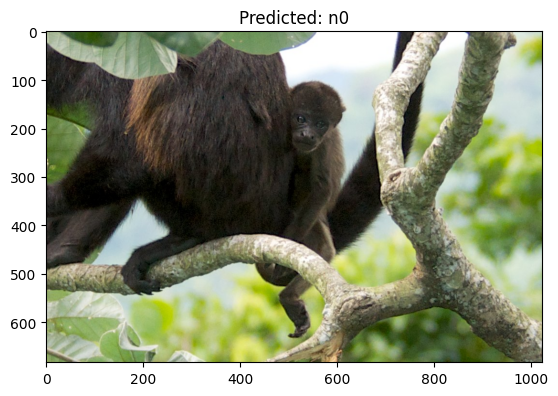

In [68]:
# Test on a sample image
def process_image(image_path):
    input_image = Image.open(image_path).resize((224, 224))  # Resize to match model input
    input_image_transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    processed_image = input_image_transformation(input_image)
    return processed_image
model.load_state_dict(torch.load('monkey_species_model.pth'))
model.eval()

image_path = '/content/validation/validation/n0/n012.jpg'


processed_image = process_image(image_path).unsqueeze(0)
processed_image = processed_image.to(device)

with torch.no_grad():
    outputs = model(processed_image)
    _, predicted = torch.max(outputs, 1)
    predicted_class = ordered_classes[predicted.item()]

# Display the image and predicted class
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.show()
